In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

#from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.models import load_model

In [2]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 5 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['item'] # details of classes

In [3]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/drg_all'   
                                                        
inv_new_image = ['/home/scar3crow/Downloads/drg_all/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)


Number of images =  40


In [4]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
        
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

,image_serial,rows,columns
37,/home/scar3crow/Downloads/drg_all/7.jpg,2480,3509
38,/home/scar3crow/Downloads/drg_all/8.jpg,2480,3509
39,/home/scar3crow/Downloads/drg_all/9.jpg,2480,3509


In [5]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.DataFrame()

r_new_data = pd.read_csv('/home/scar3crow/Downloads/via_drg_1.csv')


#r_new_data = pd.concat([r_new_data_1, r_new_data_2], axis = 0, ignore_index = True)

num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data = r_new_data[(r_new_data['#filename'] != '33.jpg') & (r_new_data['#filename'] != '20.jpg')].reset_index(drop=True)

r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
r_new_data.head(5)

Number of unique images =  38


,#filename,region_shape_attributes,region_attributes
0,1.jpg,"{""name"":""rect"",""x"":1886,""y"":1863,""width"":1457,...","{""text"":""item""}"
1,2.jpg,"{""name"":""rect"",""x"":2230,""y"":1615,""width"":1243,...","{""text"":""item""}"
2,3.jpg,"{""name"":""rect"",""x"":2143,""y"":1855,""width"":1200,...","{""text"":""item""}"
3,4.jpg,"{""name"":""rect"",""x"":2071,""y"":1840,""width"":1393,...","{""text"":""item""}"
4,5.jpg,"{""name"":""rect"",""x"":2224,""y"":1330,""width"":1140,...","{""text"":""item""}"


In [6]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]

    i_path = '/home/scar3crow/Downloads/drg_all/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[0:3]


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
0,1.jpg,0,/home/scar3crow/Downloads/drg_all/1.jpg,1886,1863,1457,107,item,3509,2480
1,2.jpg,11,/home/scar3crow/Downloads/drg_all/2.jpg,2230,1615,1243,410,item,3509,2480
2,3.jpg,22,/home/scar3crow/Downloads/drg_all/3.jpg,2143,1855,1200,115,item,3509,2480


In [7]:
## Find out image with max boxes :

max_box_image = r_new_data['img_id'].value_counts().max()
image_with_max_box =  r_new_data['img_id'].value_counts().idxmax()
print(image_with_max_box, 'with', max_box_image, 'boxes')

28.jpg with 3 boxes


In [8]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

Number of unique images =  38
Number of classes in diff. categories =  item    42
Name: obj_class, dtype: int64


In [9]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [180]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0
for i in range(num_images):
    image_line = []
    
    img = r_new_data['img_id'][limit_upper]
    kount = r_new_data['img_id'].value_counts()[img]
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_new_data[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[12])   ##  boxes are in format xmin, ymin, xmax, ymax

38
[4, '/home/scar3crow/Downloads/drg_all/13.jpg', array([[1858., 1690., 3349., 1976.]], dtype=float32), array([0]), 3509, 2480]


In [11]:
## Draw Box with sharpened image :

def draw_box_pred(img_id, box_list, label, target_size):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/home/scar3crow/Downloads/drg_all/' + image_id
#    print(image_path)

# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
        obj_class = categories[int(label[j])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

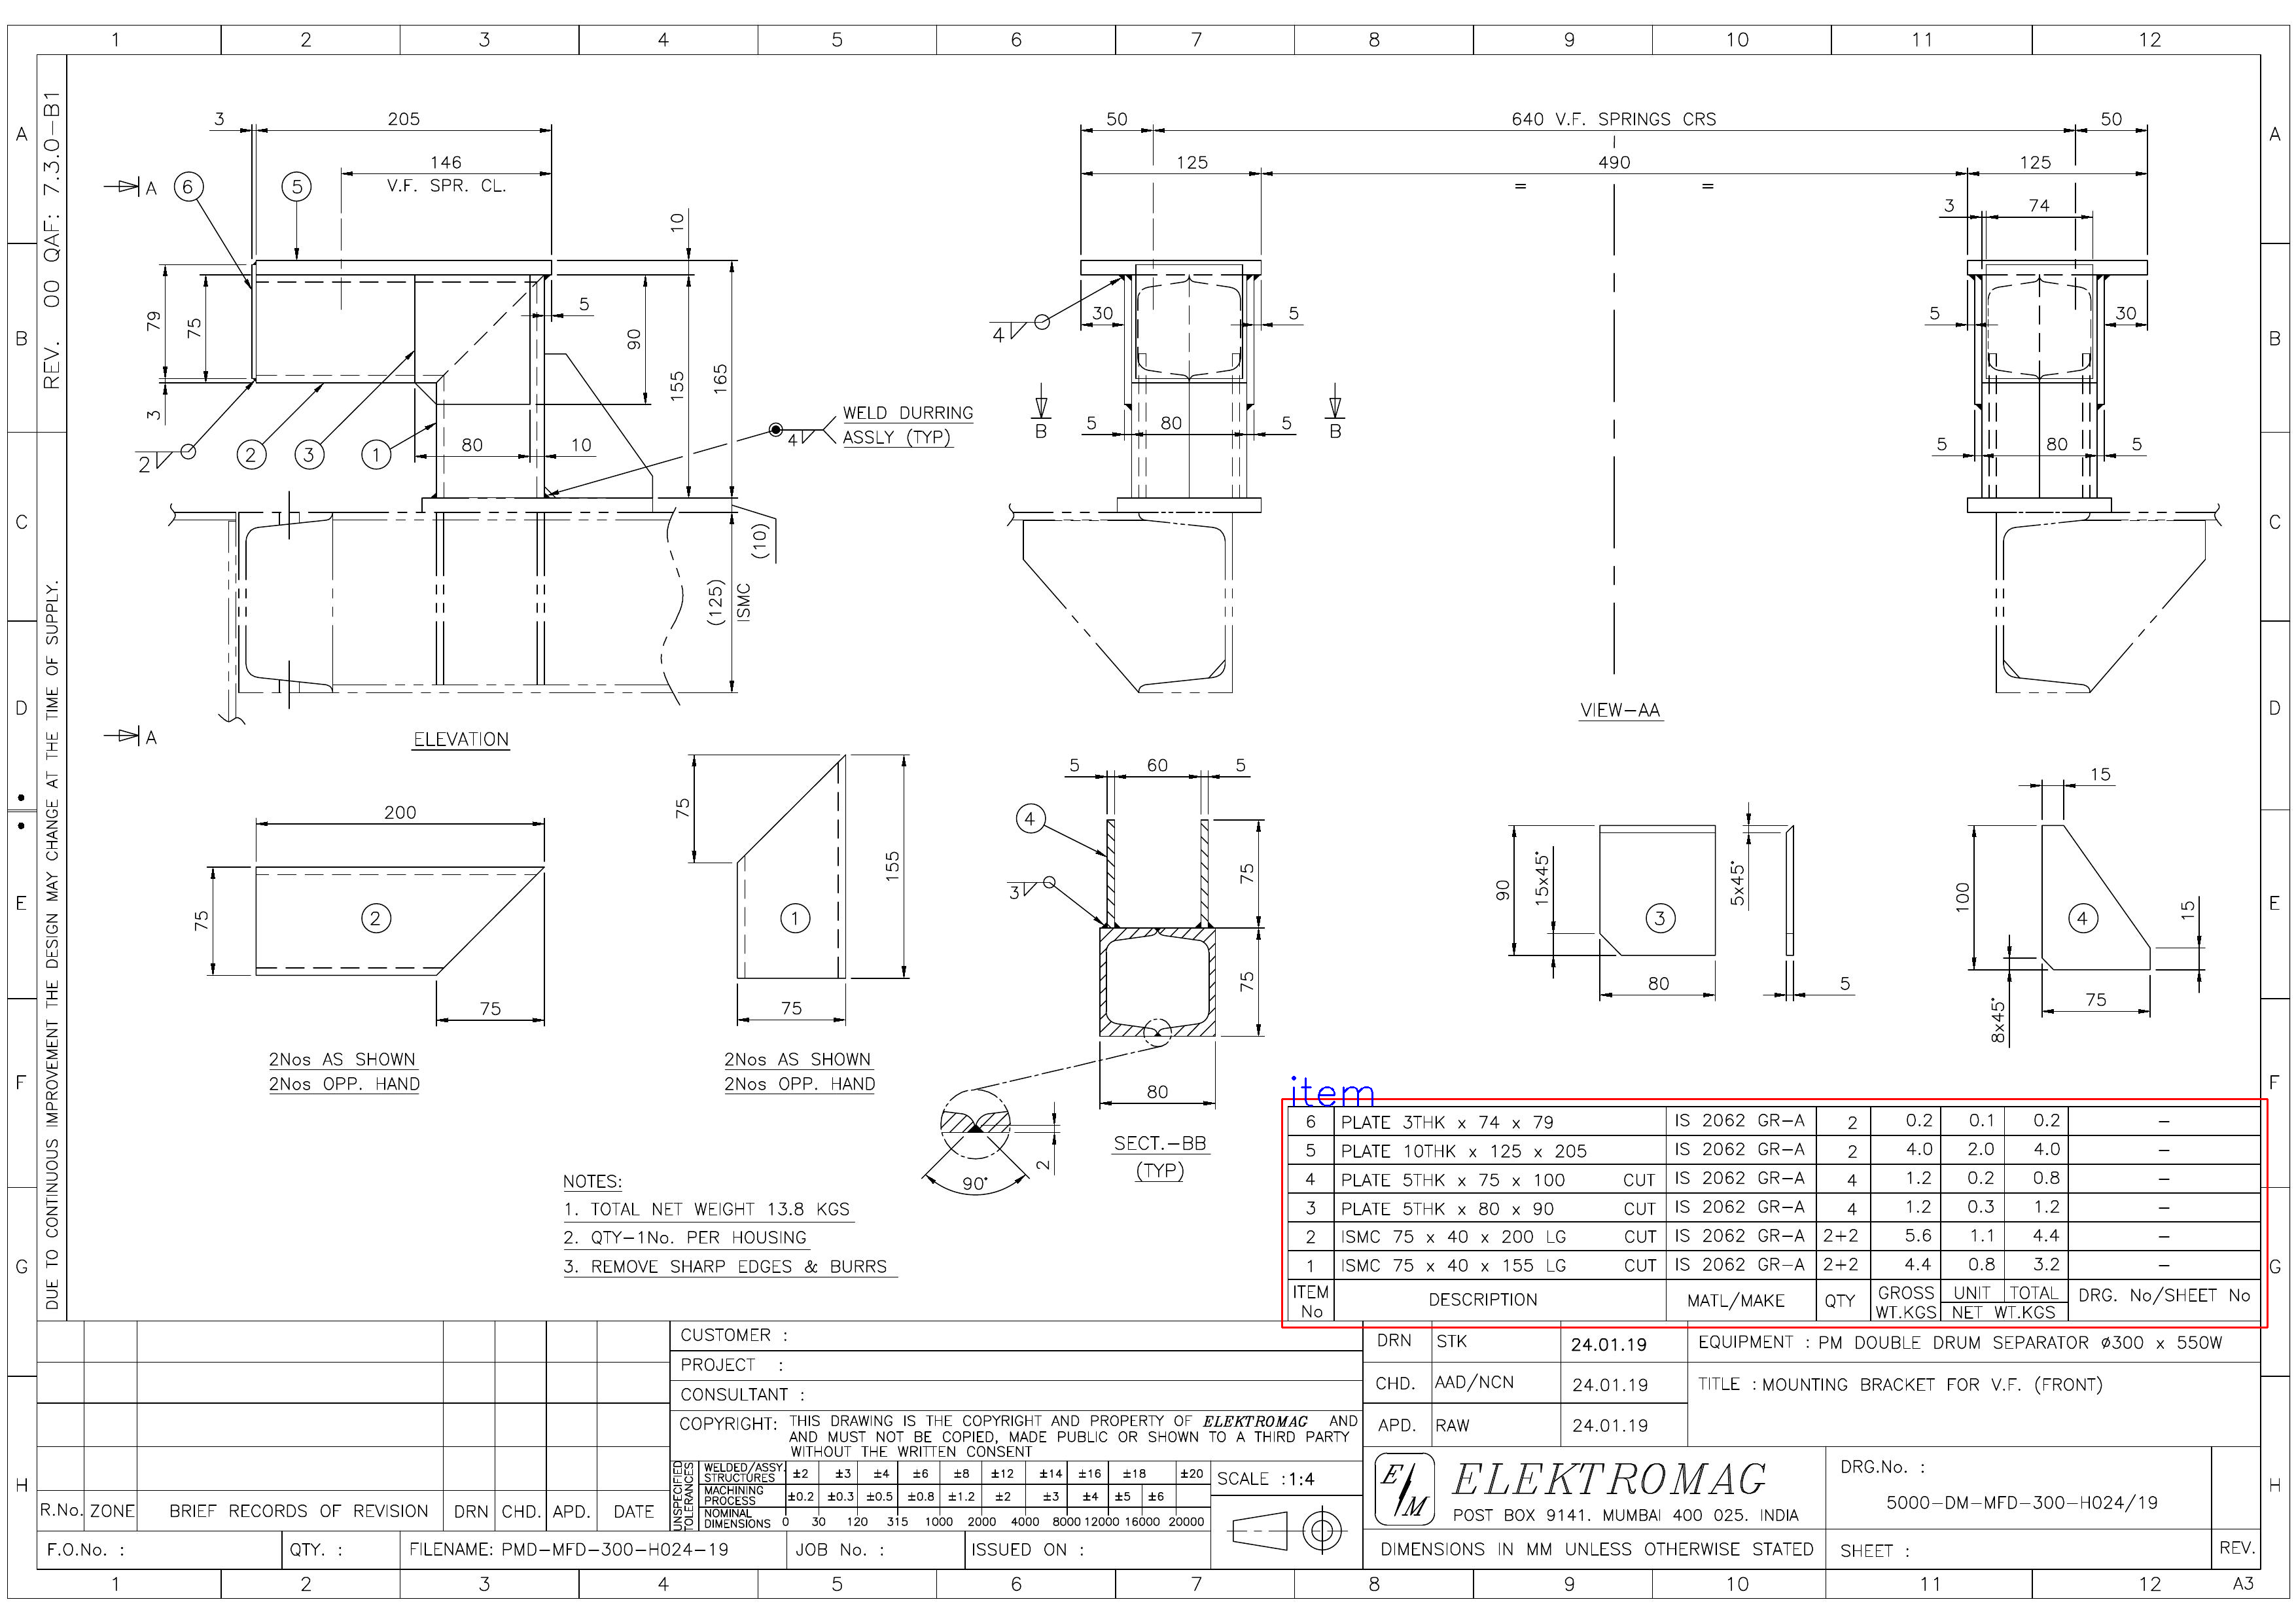

In [211]:
_,_,box_list,label,_,_ = all_image_line[13]

img_id = 14

draw_box_pred(img_id, box_list,label, target_size)


[[1959. 1679. 3465. 2028.]]


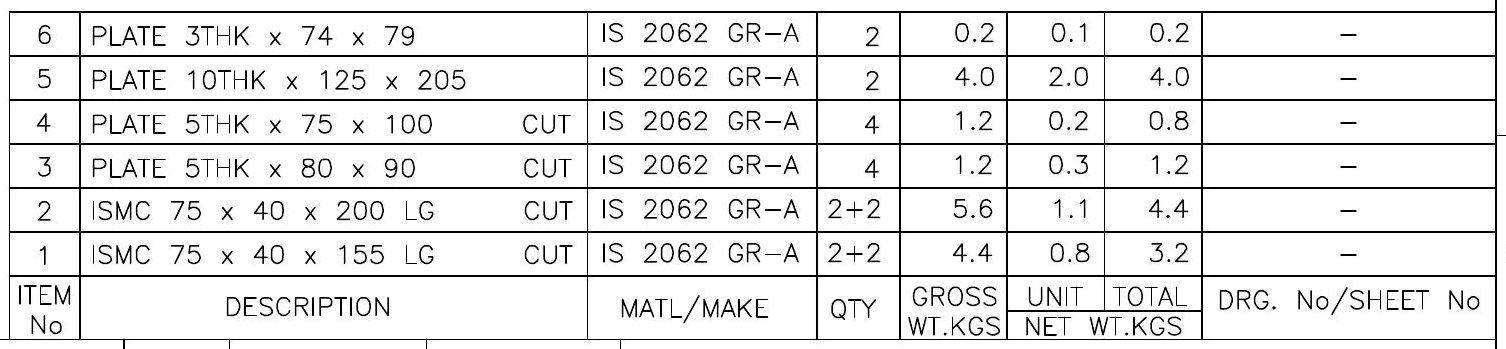

In [212]:
img_id = 14
image_id = str(img_id) + '.jpg'

image_path = '/home/scar3crow/Downloads/drg_all/' + image_id

_,_,box_list,label,_,_ = all_image_line[13]
#box_list = box_list.tolist()

print(box_list)

x = cv2.imread(image_path)

# By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
# we need to convert from BGR to RGB format/mode:
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

xx = x[int(box_list[0][1]):int(box_list[0][3]), int(box_list[0][0]):int(box_list[0][2])]
xx_gray = cv2.cvtColor(xx,cv2.COLOR_BGR2GRAY)

xx_pil = Image.fromarray(xx_gray)

display(xx_pil) 

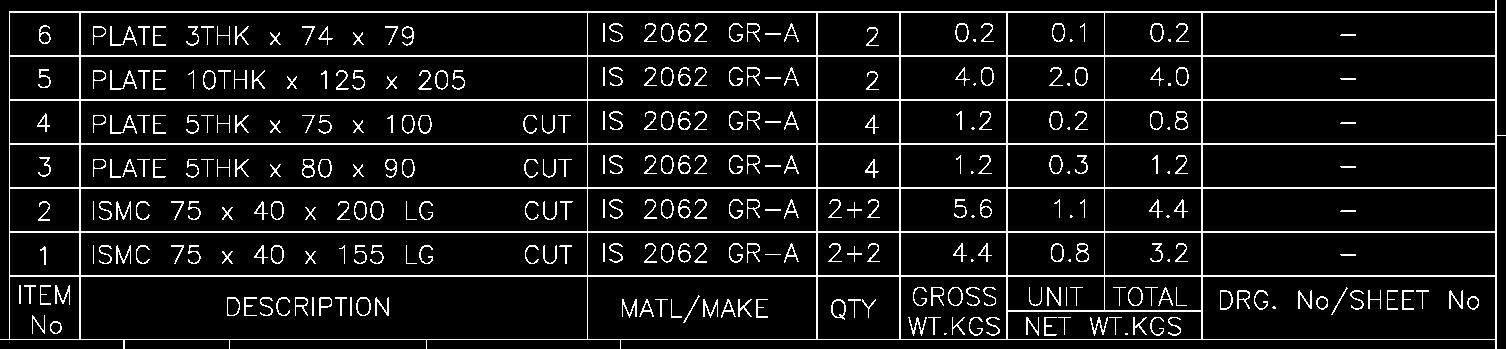

In [213]:
##thresholding the image to a binary image
thresh,img_bin = cv2.threshold(xx_gray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin_invert = 255-img_bin

img_pil = Image.fromarray(img_bin_invert)

display(img_pil) 

(349, 1506)
15
[[1 1]
 [1 1]]


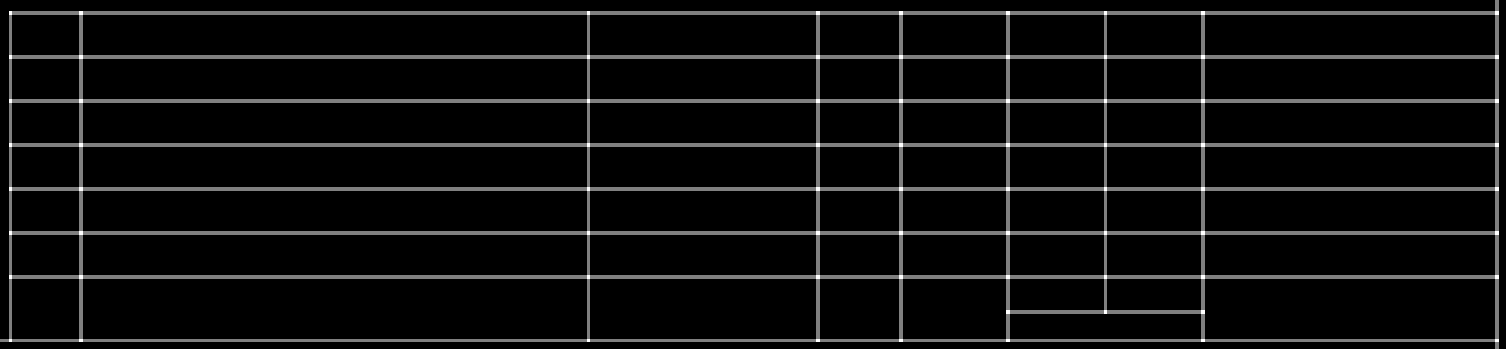

In [214]:

# Length(width) of kernel as 100th of total width
kernel_len = xx_gray.shape[1]//100
print(xx_gray.shape)
print(kernel_len)

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin_invert, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin_invert, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print(kernel)

img_vh_d = cv2.dilate(img_vh, kernel, iterations=2)

img_vh_d_pil = Image.fromarray(img_vh_d)

display(img_vh_d_pil)


In [215]:
# Defining the cell boxes

contours, hierarchy = cv2.findContours(img_vh_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

boxes = np.zeros((len(contours), 4))

for i in range(len(contours)):
    
    cnt = contours[i]
    x, y, w, h = cv2.boundingRect(cnt)
    boxes[i, 0] = x
    boxes[i, 1] = y
    boxes[i, 2] = w
    boxes[i, 3] = h

print(len(boxes))
boxes      ## ## in format x, y, w, h

58


array([[   0.,    0., 1499.,  349.],
       [1009.,  313.,  193.,   27.],
       [1204.,  278.,  292.,   62.],
       [1106.,  278.,   96.,   33.],
       [1009.,  278.,   96.,   33.],
       [ 902.,  278.,  105.,   62.],
       [ 819.,  278.,   81.,   62.],
       [ 589.,  278.,  228.,   62.],
       [  82.,  278.,  506.,   62.],
       [  11.,  278.,   69.,   62.],
       [1204.,  234.,  292.,   42.],
       [1106.,  234.,   96.,   42.],
       [1009.,  234.,   96.,   42.],
       [ 902.,  234.,  105.,   42.],
       [ 819.,  234.,   81.,   42.],
       [ 589.,  234.,  228.,   42.],
       [  82.,  234.,  506.,   42.],
       [  11.,  234.,   69.,   42.],
       [1204.,  190.,  292.,   42.],
       [1106.,  190.,   96.,   42.],
       [1009.,  190.,   96.,   42.],
       [ 902.,  190.,  105.,   42.],
       [ 819.,  190.,   81.,   42.],
       [ 589.,  190.,  228.,   42.],
       [  82.,  190.,  506.,   42.],
       [  11.,  190.,   69.,   42.],
       [1204.,  146.,  292.,   42.],
 

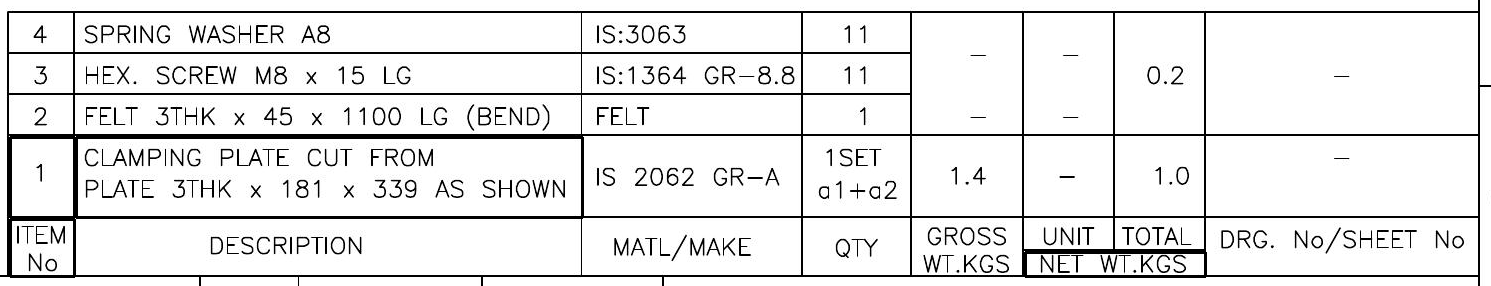

In [208]:
aa = boxes.tolist()
i = 16
bb = xx_gray

cv2.rectangle(bb, (int(aa[i][0]), int(aa[i][1])), (int(aa[i][0] + aa[i][2]), int(aa[i][1] + aa[i][3])), (0,0,255), 2)

yy_pil = Image.fromarray(bb)

display(yy_pil) 

In [209]:
aa = boxes.tolist()
i = 16
bb = xx_gray

yy_gray = bb[int(aa[i][1]):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]):int(aa[i][0] + aa[i][2] - 1)]

#thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

yy_text = pytesseract.image_to_string(yy_gray, config='--psm 6 --oem 2')

yy_text

'CLAMPING PLATE CUT FROM\nPLATE 3THK x 181 x 339 AS SHOWN'

In [216]:
boxes_1 = boxes[1:]   ## removing the full box
print(boxes_1.shape)

## Find number of columns i.e. max occurance of any y value :

y_list = boxes_1[:, 1].tolist()

col_count_array = np.bincount(y_list)  ## no. of occurances of each y-value
col_count = col_count_array.max()  ## max. no. of occurances of y-value in a row

print(col_count)

# Now fid the Header row. In drawings, header row is always at the bottom and cv2.boundingRect always starts,
# after the 1st row, from bottom right

# So, y value of boxes[1] is the bottom_most-right_most  cell y value.

y_bmrm_cell = boxes_1[0][1]

num_col = y_list.count(y_bmrm_cell)   ## no. of occurances of y_bmrm_cell value

print(num_col)

if num_col == col_count:
    
    y_header_row = y_bmrm_cell
    
    print(y_header_row)
    
else:
        
    bom_boxes_1 = boxes_1[1:]  ## remove 1st row for bom consideration
    y_next_cell = boxes_1[1][1]

    num_col = y_list.count(y_next_cell)

    print(num_col)

    if num_col == col_count:
    
        y_header_row = y_next_cell

    print(y_header_row)

header_boxes = boxes_1[boxes_1[:, 1] == y_header_row]

print(bom_boxes_1.shape)

header_boxes


(57, 4)
8
1
8
278.0
(56, 4)


array([[1204.,  278.,  292.,   62.],
       [1106.,  278.,   96.,   33.],
       [1009.,  278.,   96.,   33.],
       [ 902.,  278.,  105.,   62.],
       [ 819.,  278.,   81.,   62.],
       [ 589.,  278.,  228.,   62.],
       [  82.,  278.,  506.,   62.],
       [  11.,  278.,   69.,   62.]])

In [18]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    

    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [217]:
aa = header_boxes
header_text = []

for i in range(len(aa)):
    
    yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]):int(aa[i][0] + aa[i][2] - 1)]
    
    thresh, yy_gray_1 = cv2.threshold(yy_gray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    text = pytesseract.image_to_string(yy_gray_1, config='--psm 6 --oem 2')

    header_text.append(text)
    
serialised_header_text = header_text[::-1]

print(serialised_header_text)


['ITEM\nNo', 'DESCRIPTION', 'MATL/MAKE', 'QaTy', 'GROSS\nWITKCGS', 'UNIT', 'TOTAL', 'DRG. No/SHEET No']


In [218]:
bom_boxes = bom_boxes_1[bom_boxes_1[:, 1] != y_header_row]

print(bom_boxes.shape)

#print(bom_boxes)

y_unique = np.unique(bom_boxes[:,1])
y_unique = y_unique[::-1]

num_item = len(y_unique)

print(y_unique)

bom_text = []

for i in y_unique:
    
    bom_sub_text = []
    
    aa = bom_boxes[bom_boxes[:, 1] == i]

    for i in range(len(aa)):
    
#        thresh, xx_gray_1 = cv2.threshold(xx_gray,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
        yy_gray = xx_gray[int(aa[i][1]):int(aa[i][1] + aa[i][3] - 1), int(aa[i][0]):int(aa[i][0] + aa[i][2] - 1)]
        
        text = pytesseract.image_to_string(yy_gray, config='--psm 6 --oem 3')
        
        bom_sub_text.append(text)
        
#        bom_sub_text.append(text)
    
    bom_sub_text_rev = bom_sub_text[::-1]
    bom_text.append(bom_sub_text_rev)
    
print(bom_text)
print('=============================')
print(bom_text[0])


(48, 4)
[234. 190. 146. 102.  58.  14.]
[['1', 'ISMC 75 x 40 x 155 LG CUT', 'IS 2062 GR—A', '2+2', '4.4', '0.8', '3.2', ''], ['2', 'ISMC 75 x 40 x 200 LG CUT', 'IS 2062 GR—A', '2+2', '5.6', '1.1', '4.4', ''], ['3', 'PLATE STHK x 80 x 90 CUT', 'IS 2062 GR—A', '4', '1.2', '0.3', '1.2', ''], ['4', 'PLATE STHK x 75 x 100 CUT', 'IS 2062 GR—A', '4', '1.2', '0.2', '0.8', ''], ['5', 'PLATE 10THK x 125 x 205', 'IS 2062 GR—A', '2', '4.0', '2.0', '4.0', ''], ['6', 'PLATE 3THK x 74 x 79', 'IS 2062 GR—A', '2', '0.2', '0.1', '0.2', '']]
['1', 'ISMC 75 x 40 x 155 LG CUT', 'IS 2062 GR—A', '2+2', '4.4', '0.8', '3.2', '']


In [221]:
#Creating a dataframe of the generated OCR list
arr = np.array(bom_text)
print(arr.shape)
dataframe = pd.DataFrame(arr.reshape(num_item, num_col), columns = serialised_header_text)
#print(dataframe)
#data = dataframe.style.set_properties(align="left")
dataframe.head()

(6, 8)


,ITEM No,DESCRIPTION,MATL/MAKE,QaTy,GROSS WITKCGS,UNIT,TOTAL,DRG. No/SHEET No
0,1,ISMC 75 x 40 x 155 LG CUT,IS 2062 GR—A,2+2,4.4,0.8,3.2,
1,2,ISMC 75 x 40 x 200 LG CUT,IS 2062 GR—A,2+2,5.6,1.1,4.4,
2,3,PLATE STHK x 80 x 90 CUT,IS 2062 GR—A,4,1.2,0.3,1.2,
3,4,PLATE STHK x 75 x 100 CUT,IS 2062 GR—A,4,1.2,0.2,0.8,
4,5,PLATE 10THK x 125 x 205,IS 2062 GR—A,2,4.0,2.0,4.0,


In [222]:
arr = np.array(bom_text)
arr.shape

(6, 8)

In [193]:
print(num_col)
num_item

8


4